# Advance Machine Learning

## PUBG Finish Placement Prediction

### Team Member
#### Palazzi Bruno - 806908
#### Giacomo Villa - 807462

# TO DO


# Attributes
* assists: Number of enemy players this player damaged that were killed by teammates.
* boosts: Number of boost items used.
* damageDealt: Total damage dealt. Note: Self inflicted damage is subtracted.
* DBNOs: Number of enemy players knocked.
* headshotKills: Number of enemy players killed with headshots.
* heals: Number of healing items used.
* killPlace: Ranking in match of number of enemy players killed.
* killPoints: Kills-based external ranking of player.
* kills: Number of enemy players killed. 
* killStreaks: Max number of enemy players killed in a short amount of time.
* longestKill: Longest distance between player and player killed at time of death.
* matchDuration: Duration of match in seconds.
* matchType: String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches. 
* numGroups: Number of groups we have data for in the match.
* revives: Number of times this player revived teammates.
* rideDistance: Total distance traveled in vehicles measured in meters.
* roadKills: Number of kills while in a vehicle.
* swimDistance: Total distance traveled by swimming measured in meters.
* teamKills: Number of times this player killed a teammate.
* vehicleDestroys: Number of vehicles destroyed.
* walkDistance: Total distance traveled on foot measured in meters.
* weaponsAcquired: Number of weapons picked up.
* winPoints: Win-based external ranking of player. 
* maxPlace: Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements. 

# Libraries

In [15]:
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt

import seaborn as sns

import collections

import statistics 

import numpy as np

from pyGPGO.surrogates.RandomForest import RandomForest
from pyGPGO.GPGO import GPGO
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

import keras 
from keras.utils import np_utils
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Input
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler

# Function

In [31]:
def load_data():
    fields = ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace',
             'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'matchType', 
              'numGroups', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
               'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints', 'winPlacePerc']
    data = pd.read_csv('../data/dataset.csv', usecols=fields)
    # data = data['matchType' == 'squad-fpp']
    print("START DATASET")
    print(data.head(5))
    print("NUMBER OF ROWS: ", len(data))
    print("")
    return data

def select_typology(data, typology):
    
    if typology == 'solo-fpp':
        del data['DBNOs']
        del data['revives']
        
        
    data = data[data.matchType == typology]
    del data['matchType']
    print("SELECT TASK DATASET")
    print(data.head(5))
    print("NUMBER OF ROWS: ", len(data))
    print("")
    
    return data

def transform_task(data):
    labels = list()
    scores = data.winPlacePerc
    for score in scores:
        score = round(score, 2)
        if score >= 0 and score <= 0.2:
            labels.append(0)
        elif score >= 0.21 and score <= 0.4:
            labels.append(1)
        elif score >= 0.41 and score <= 0.6:
            labels.append(2)
        elif score >= 0.61 and score <= 0.8:
            labels.append(3)
        elif score >= 0.81 and score <= 1:
            labels.append(4)
        else:
            print("PROBLEMS VALUES: ", score)
            labels.append(-1)
    
    del data['winPlacePerc']
    
    data['label'] = labels
    
    data = data.drop(data[data.label == -1].index)
    
    print("CHANGE TASK DATASET")
    print(data.head(5))
    print("NUMBER OF ROWS: ", len(data))
    print("")
    return data


def preprocessing_data(dataset):
    
    data = dataset.values.copy()
    
    x = data[:, 0:-1].astype(np.float32) 
    y = data[:, -1]
    y = np_utils.to_categorical(y, 5)
    
    scaler = StandardScaler()
    scaler.fit(data)
    data = scaler.transform(data)
    
    return x, y

def print_correlation_matrix(dataset):
    corr = dataset.corr()
    plt.subplots(figsize=(15, 15))
    plot = sns.heatmap(corr, xticklabels = corr.columns.values, yticklabels = corr.columns.values,
                      linewidths=.3, vmin=-1, vmax=1, annot=True)
    
def print_distribution(dataset):
    fig1, ax1 = plt.subplots()
    number = dataset["label"].value_counts()
    number = dict(collections.OrderedDict(sorted(number.items())))
    show = list()
    print(number)
    for value in number:
        show.append(number[value])
    print(show)
    ax1.pie(show, explode = (0, 0, 0, 0, 0.2), labels = ['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'],
            autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')
    plt.show()
    
def print_kills_number(kills):
    
    plt.figure(figsize=(15,10))
    
    plt.title("Kills")
    plt.xlabel("# kills")
    plt.ylabel("times")
    
    kills_number = [0]*10
    names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']
    
    for kill in kills:
        if kill >= 10:
            kills_number[9] += 1
        else:
            kills_number[kill] += 1
            
    print(kills_number)
    plt.bar(np.arange(10), height = kills_number)
    plt.show()

def print_sns_hist(value, name):
    plt.figure(figsize=(15, 10))
    value.name = name
    sns.distplot(value)
    
def print_sns_join_plot(x_value, y_value, dataset):
    sns.jointplot(x_value, y_value, dataset, ratio=3, height=15)
    plt.show()

def print_sns_pairplot(dataset, based):
    plt.figure(figsize=(60, 60))
    sns.set(font_scale=5)
    g = sns.pairplot(dataset, vars=["killPlace", "weaponsAcquired", "kills", "damageDealt", "walkDistance"],
                     hue="label", markers=["o", "x"], height = 10)
    new_labels = ['Low', 'High']
    for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
    for i, j in zip(*np.triu_indices_from(g.axes, 1)):
        g.axes[i, j].set_visible(False)
    plt.show()
    sns.set()
    
def plotConfusionMatrix(y_true, y_pred, classes, normalize, title, cmap = plt.cm.get_cmap("Blues")):
    
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap= cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    plt.show(ax)
    
def define_net(first_layer, second_layer, opt, input_size):
    model = Sequential()
    model.add(Dense(first_layer, input_shape = (input_size,), activation='relu'))
    model.add(Dropout(0.4, noise_shape=None, seed=None))
    model.add(Dense(second_layer, activation='relu'))
    model.add(Dropout(0.4, noise_shape=None, seed=None))
    model.add(Dense(5))
    model.add(Activation('softmax'))
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])  
    return model

# optimizers:
# 0: SGD, 1: RMSprop, 2: Adagrad, 3: Adadelta
    
def compute_accuracy(conf_lr, conf_mom, conf_rho, conf_fl, conf_sl, conf_opt):
    
    kfold = StratifiedKFold(n_splits = 3, shuffle=False)
    
    if conf_opt == 0:
        opt = optimizers.SGD(conf_lr, conf_mom)
        print("{:<21}{:>5}".format("TRY OPTIMIERS: ", "SGD"))
        print("{:<21}{:>5}".format("TRY LEARNING RATE: ", round(conf_lr, 5)))
        print("{:<21}{:>5}".format("TRY MOMENTUM:", round(conf_mom, 5)))
    elif conf_opt == 1:
        opt = optimizers.RMSprop(conf_lr, conf_rho)
        print("{:<21}{:>5}".format("TRY OPTIMIERS: ", "RMSprop"))
        print("{:<21}{:>5}".format("TRY LEARNING RATE: ", round(conf_lr, 5)))
        print("{:<21}{:>5}".format("TRY RHO:", round(conf_rho, 5)))
    elif conf_opt == 2:
        opt = optimizers.Adagrad(conf_lr)
        print("{:<21}{:>5}".format("TRY OPTIMIERS: ", "Adagrad"))
        print("{:<21}{:>5}".format("TRY LEARNING RATE: ", round(conf_lr, 5)))
    else:
        opt = optimizers.Adadelta(conf_lr, conf_rho)
        print("{:<21}{:>5}".format("TRY OPTIMIERS: ", "Adadelta"))
        print("{:<21}{:>5}".format("TRY LEARNING RATE: ", round(conf_lr, 5)))  
        print("{:<21}{:>5}".format("TRY RHO:", round(conf_rho, 5)))
        
    print("{:<21}{:>5}".format("TRY FIRST LAYER: ", int(conf_fl)))
    print("{:<21}{:>5}".format("TRY SECOND LAYER: ", int(conf_sl)))

    
    data, label = preprocessing_data(typology_data)
    
    es = EarlyStopping(monitor='val_accuracy', patience = 5, verbose = 2, restore_best_weights = True)
    
    cvscores = []
    
    fold = 0
    
    label_noOneHot = typology_data.values.copy()[:, -1]
    
    for train, test in kfold.split(data, label_noOneHot):
        
        x_test_real, x_val, y_test_real, y_val = train_test_split(data[test], label[test],
                                                                  test_size = 0.2)
        
        model = define_net(int(conf_fl), int(conf_sl), opt, 20)
        
        model.fit(data[train], label[train], epochs=200, batch_size=256, verbose = 2, validation_data=(x_val, y_val), 
                                    callbacks = [es])
        
        scores = model.evaluate(x_test_real, y_test_real, verbose = 0)
        labels_predict = model.predict_classes(x_test_real)
        
        for predict in labels_predict:
            prediction.append(predict)
        
        for label in y_test_real:    
            labels_real.append(np.where(label == np.amax(label))[0][0])
        
        prediction_array = np.array(real_prediction)
        labels_real_array = np.array(labels_real)
        
        plotConfusionMatrix(labels_real_array, prediction_array, ['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'],
                        False, "Confusion Matrix fold: " + str(fold + 1))
        
        cvscores.append(scores)
        
        prediction.clear()
        labels_real.clear()
        
        fold += 1

    
    '''if len(best_seen) == 0:
        best_seen.append(np.mean(cvscores))
    else:
        if np.mean(cvscores) > max(best_seen):
            best_seen.append(np.mean(cvscores))
        else:
            best_seen.append(best_seen[-1])
            
    seen.append(np.mean(cvscores))'''
    
    return (np.mean(cvscores))

# Loading Data

In [4]:
data = load_data()
changed_task_data = transform_task(data)
typology_data = select_typology(changed_task_data, 'solo-fpp')

START DATASET
   assists  boosts  damageDealt  DBNOs  headshotKills  heals  killPlace  \
0        0       0         0.00      0              0      0         60   
1        0       0        91.47      0              0      0         57   
2        1       0        68.00      0              0      0         47   
3        0       0        32.90      0              0      0         75   
4        0       0       100.00      0              0      0         45   

   killPoints  kills  killStreaks  ...  revives  rideDistance roadKills  \
0        1241      0            0  ...        0        0.0000         0   
1           0      0            0  ...        0        0.0045         0   
2           0      0            0  ...        0        0.0000         0   
3           0      0            0  ...        0        0.0000         0   
4           0      1            1  ...        0        0.0000         0   

   swimDistance  teamKills  vehicleDestroys  walkDistance  weaponsAcquired  \
0     

# Data Analysis

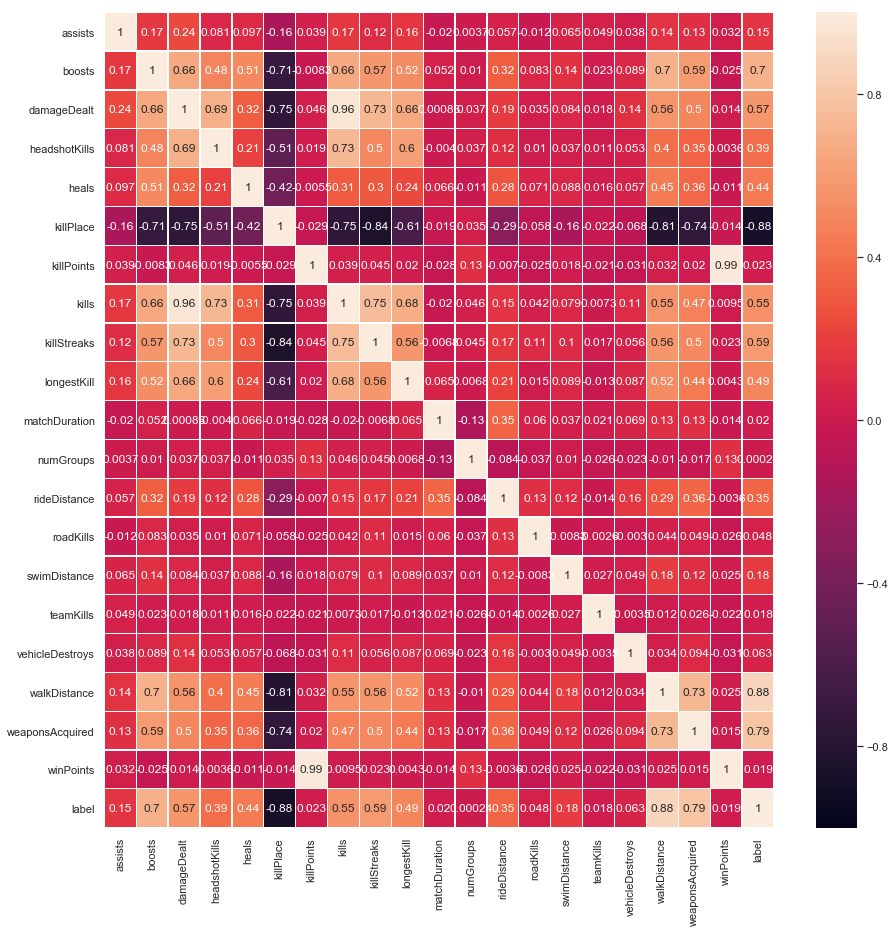

In [36]:
print_correlation_matrix(match_dataset)

In [ ]:
print_distribution(typology_data)

In [58]:
print("NUMBER OF ROW: ", len(typology_data))

NUMBER OF ROW:  536761


### Kills 

In [ ]:
avg_kill = statistics.mean(typology_data.kills)
print("{:<25}{:>5}".format("AVERAGE KILLS IN A MATCH:", round(avg_kill, 3)))

In [ ]:
print_kills_number(typology_data.kills)

### Walk

In [ ]:
print("{:<20}{:>6}".format("PLAYERS DIED IMMEDIATELY:",len(typology_data[typology_data.walkDistance == 0])))

In [ ]:
print_sns_hist(typology_data.walkDistance, "Walking Distance")

### Damage

In [ ]:
avg_damage = statistics.mean(typology_data.damageDealt)
print("{:<25}{:>5}".format("AVERAGE DAMAGE IN A MATCH: ", round(avg_damage, 3)))

In [ ]:
print_sns_hist(typology_data.damageDealt, "Damage inflicted")

### Walking x Damage

In [ ]:
print_sns_join_plot("walkDistance", "damageDealt", typology_data)

### Walking x Kills

In [ ]:
print_sns_join_plot("walkDistance", "kills", typology_data)

### Damage x Kills

In [ ]:
print_sns_join_plot("damageDealt", "kills", typology_data)

### Walking x Swimming

In [ ]:
print_sns_join_plot("walkDistance", "swimDistance", typology_data)

### Weapons pick up x Kills 

In [ ]:
print_sns_join_plot("weaponsAcquired", "kills", typology_data)

### Boosts x Kills 

In [ ]:
print_sns_join_plot("boosts", "kills", typology_data)

### High vs Low class study

<Figure size 4320x4320 with 0 Axes>

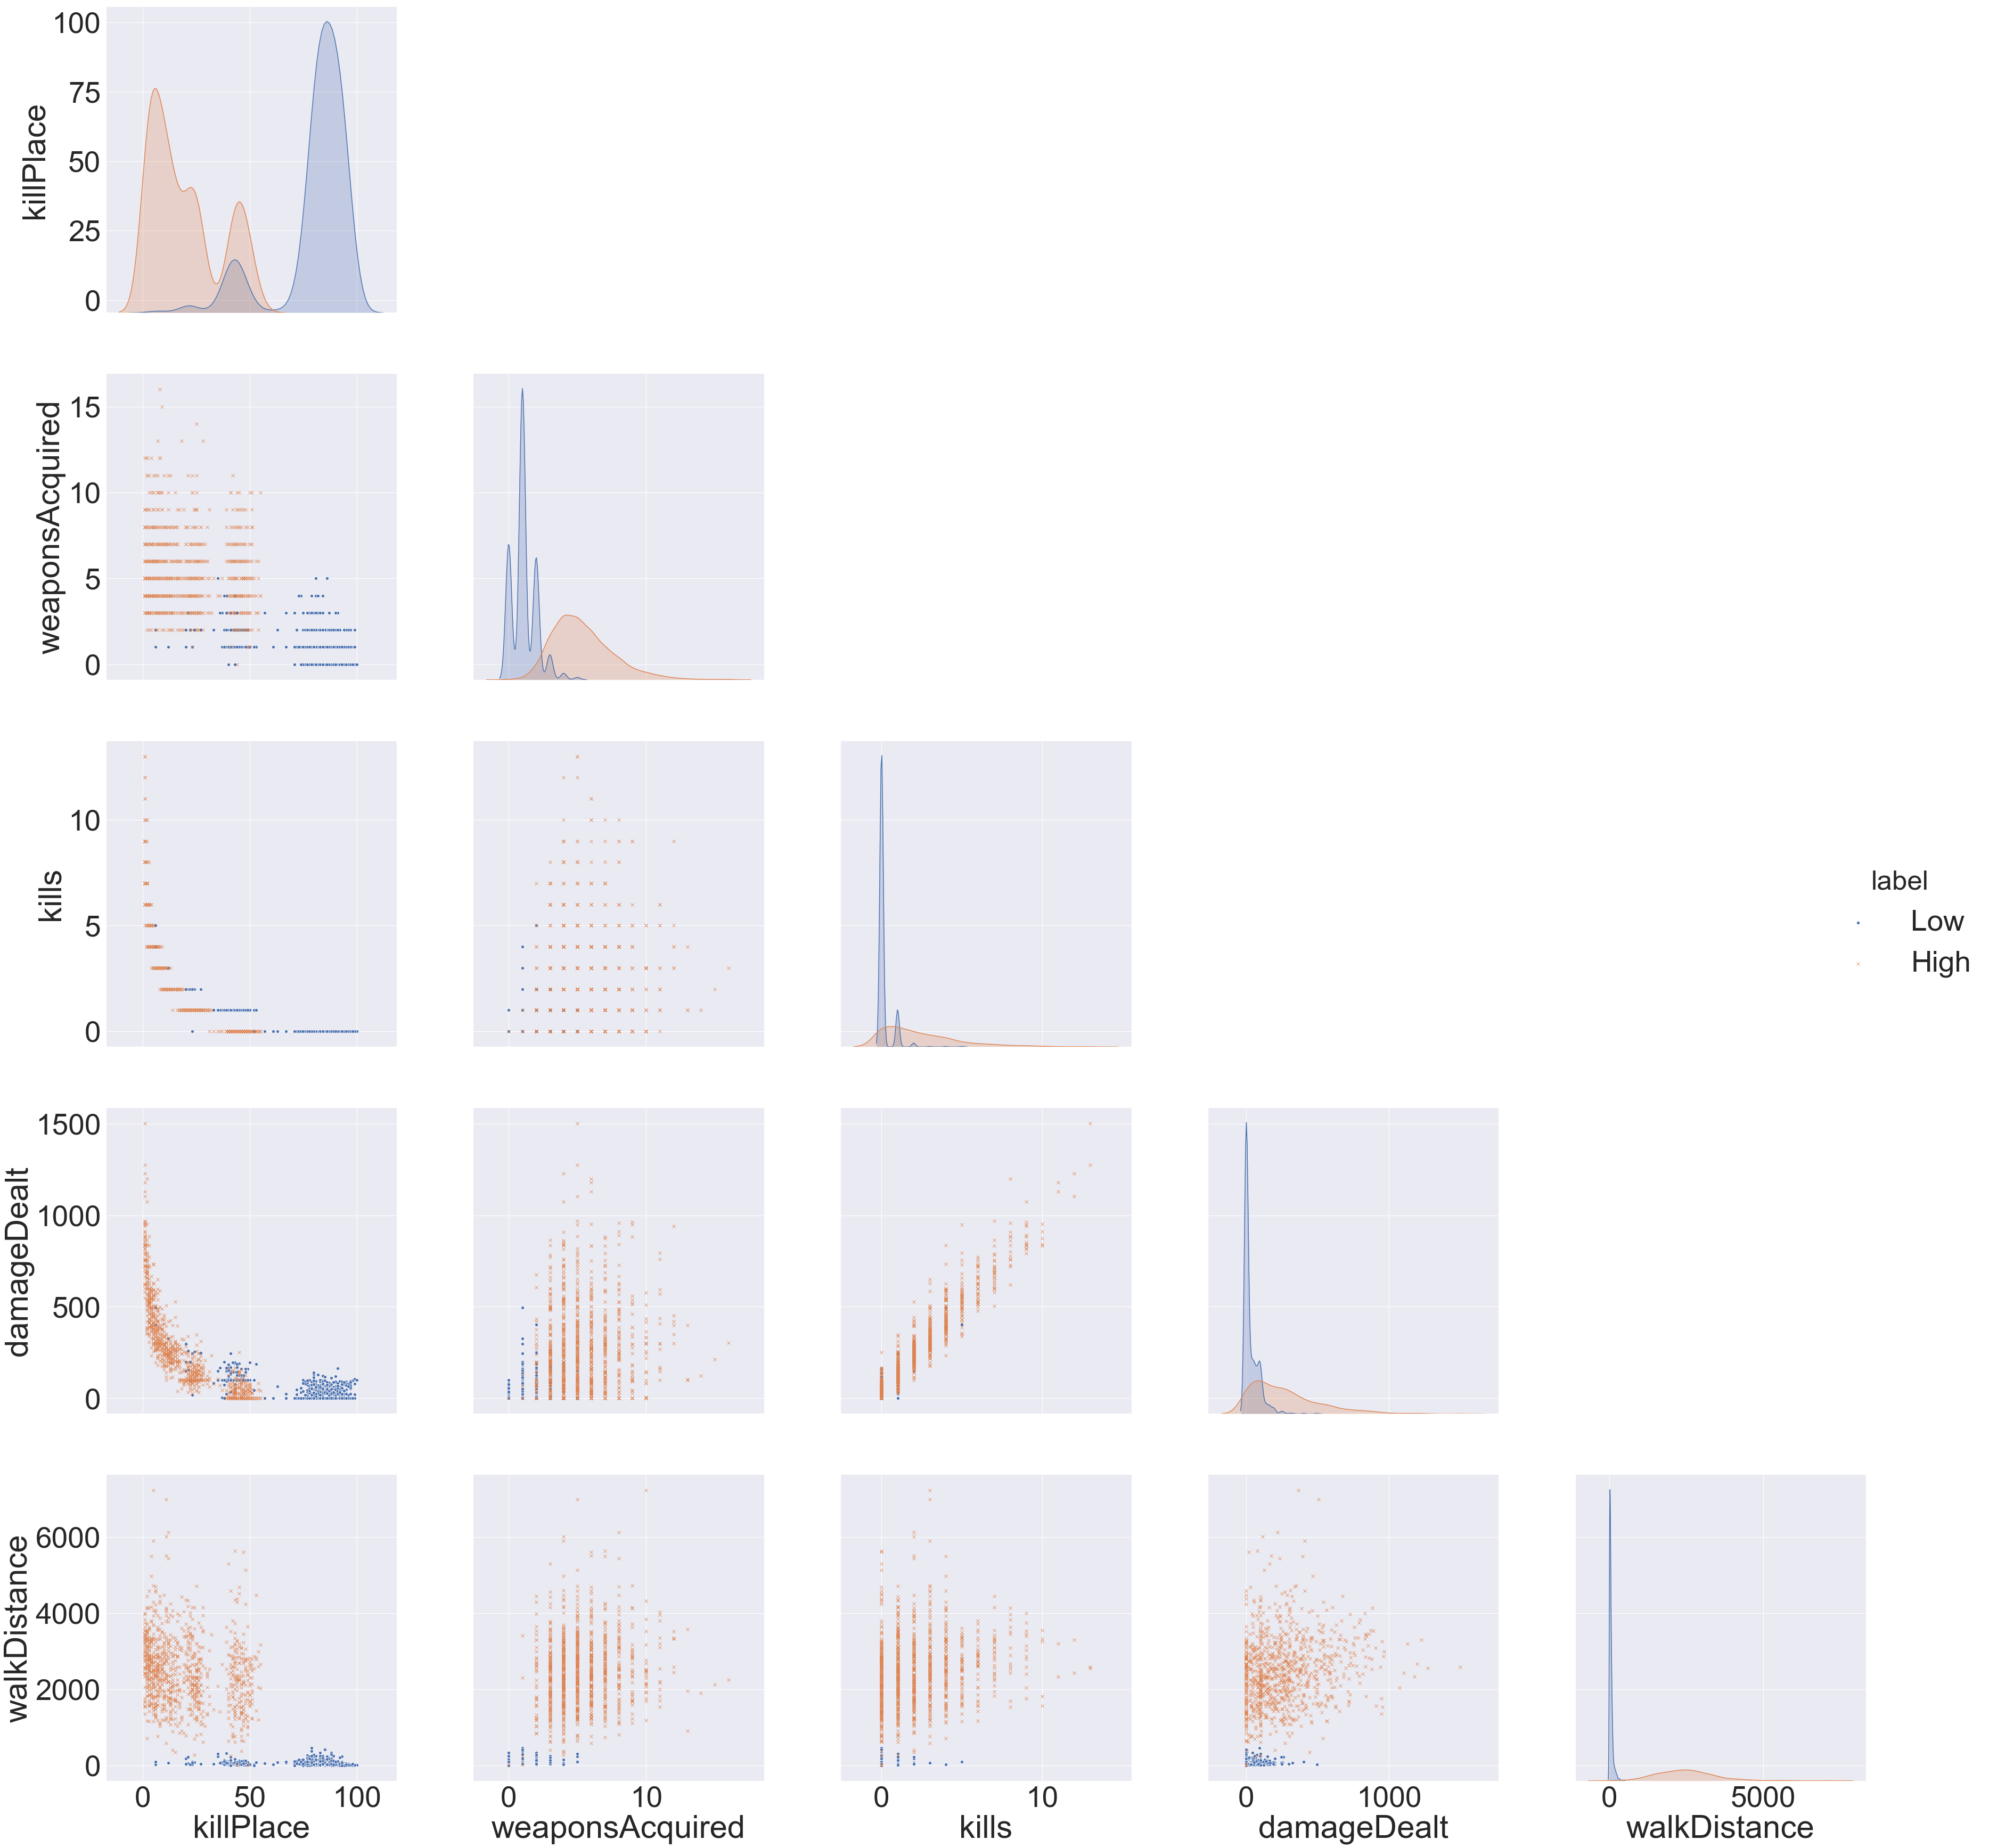

In [46]:
high = typology_data[typology_data.label == 4]
low = typology_data[typology_data.label == 0]
match_dataset = pd.concat([high[0:1000], low[0:1000]])
print_sns_pairplot(match_dataset, 'label')

In [ ]:
avg_kill = statistics.mean(high.kills)
print("{:<32}{:>5}".format("AVERAGE KILLS FOR PRO PLAYERS:", round(avg_kill, 3)))
print("{:<32}{:>5}".format("MAX KILLS BY PRO PLAYES:", max(high.kills)))
print("{:<32}{:>5}".format("MIN KILLS BY PRO PLAYES:", min(high.kills)))

In [ ]:
print_kills_number(high.kills)

In [ ]:
print_sns_hist(high.walkDistance, "Walking Distance")

In [ ]:
print_sns_hist(high.damageDealt, "Damage inflicted")

# Optimization

In [16]:
iterations = 10
param = {'learning_rate': ('cont', [0.001,0.1]), 'momentum': ('cont', [0.1, 0.9]), 'rho': ('cont', [0.1, 0.95]),
         'first_layer': ('int', [100, 300]), 'second_layer': ('int', [50, 100]), 'optimizers': ('int', [0, 3])}
sur_model = RandomForest()
acq = Acquisition(mode="ExpectedImprovement")

# Performance Analysis

In [32]:
compute_accuracy(0.1, 0.8, 0.2, 200, 100, 3)

TRY OPTIMIERS:       Adadelta
TRY LEARNING RATE:     0.1
TRY RHO:               0.2
TRY FIRST LAYER:       200
TRY SECOND LAYER:      100
Train on 357839 samples, validate on 35785 samples
Epoch 1/200
 - 3s - loss: 50.8864 - accuracy: 0.3914 - val_loss: 1.4059 - val_accuracy: 0.3660
Epoch 2/200
 - 3s - loss: 2.6622 - accuracy: 0.4452 - val_loss: 1.0951 - val_accuracy: 0.6161
Epoch 3/200
 - 3s - loss: 1.6454 - accuracy: 0.5091 - val_loss: 0.9891 - val_accuracy: 0.6532
Epoch 4/200
 - 3s - loss: 1.4032 - accuracy: 0.5469 - val_loss: 0.9412 - val_accuracy: 0.6604
Epoch 5/200
 - 3s - loss: 1.2881 - accuracy: 0.5736 - val_loss: 0.8996 - val_accuracy: 0.6644
Epoch 6/200
 - 3s - loss: 1.2110 - accuracy: 0.5936 - val_loss: 0.8712 - val_accuracy: 0.6739
Epoch 7/200
 - 3s - loss: 1.1741 - accuracy: 0.6077 - val_loss: 0.8570 - val_accuracy: 0.6733
Epoch 8/200
 - 3s - loss: 1.1365 - accuracy: 0.6178 - val_loss: 0.8380 - val_accuracy: 0.6756
Epoch 9/200
 - 3s - loss: 1.1217 - accuracy: 0.6266 - val_

Epoch 86/200
 - 3s - loss: 0.6251 - accuracy: 0.7561 - val_loss: 0.5343 - val_accuracy: 0.7813
Epoch 87/200
 - 3s - loss: 0.6273 - accuracy: 0.7562 - val_loss: 0.5288 - val_accuracy: 0.7839
Epoch 88/200
 - 3s - loss: 0.6232 - accuracy: 0.7564 - val_loss: 0.5292 - val_accuracy: 0.7847
Epoch 89/200
 - 3s - loss: 0.6269 - accuracy: 0.7563 - val_loss: 0.5287 - val_accuracy: 0.7836
Epoch 90/200
 - 3s - loss: 0.6238 - accuracy: 0.7565 - val_loss: 0.5285 - val_accuracy: 0.7840
Epoch 91/200
 - 3s - loss: 0.6244 - accuracy: 0.7576 - val_loss: 0.5322 - val_accuracy: 0.7827
Epoch 92/200
 - 3s - loss: 0.6231 - accuracy: 0.7579 - val_loss: 0.5234 - val_accuracy: 0.7853
Epoch 93/200
 - 3s - loss: 0.6199 - accuracy: 0.7586 - val_loss: 0.5277 - val_accuracy: 0.7831
Epoch 94/200
 - 3s - loss: 0.6229 - accuracy: 0.7582 - val_loss: 0.5285 - val_accuracy: 0.7856
Epoch 95/200
 - 3s - loss: 0.6212 - accuracy: 0.7577 - val_loss: 0.5245 - val_accuracy: 0.7832
Epoch 96/200
 - 3s - loss: 0.6163 - accuracy: 0.75

NameError: name 'prediction' is not defined